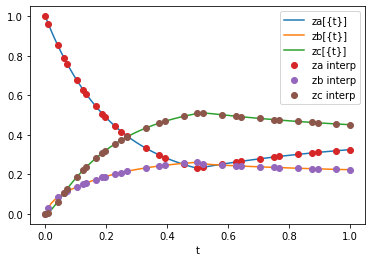

In [1]:
from pyomo.environ import *
from pyomo.dae import *
from pyomo.dae.simulator import Simulator


def create_model():
    m = ConcreteModel()

    m.t = ContinuousSet(bounds=(0.0, 1), initialize=[0.5])

    def _p1_init(m, t):
        if t >= 0.5:
            return 1.0
        return 4.0

    m.p1 = Param(m.t, initialize=4.0, default=_p1_init)
    m.p2 = Param(initialize=2.0)
    m.p3 = Param(initialize=40.0)
    m.p4 = Param(initialize=20.0)

    m.za = Var(m.t)
    m.zb = Var(m.t)
    m.zc = Var(m.t)
    m.dza = DerivativeVar(m.za)
    m.dzb = DerivativeVar(m.zb)

    # Setting the initial conditions
    m.za[0.0] = 1
    m.zb[0.0] = 0

    # Setting the time-varying profile
    p1_profile = {0: 4.0, 0.5: 1.0}
    m.var_input = Suffix(direction=Suffix.LOCAL)
    m.var_input[m.p1] = p1_profile

    def _diffeq1(m, t):
        return m.dza[t] == -m.p1[t] * m.za[t] + m.p2 * m.zb[t]

    m.diffeq1 = Constraint(m.t, rule=_diffeq1)

    def _diffeq2(m, t):
        return m.dzb[t] == m.p1[t] * m.za[t] - (m.p2 + m.p3) * m.zb[t] + m.p4 * m.zc[t]

    m.diffeq2 = Constraint(m.t, rule=_diffeq2)

    def _algeq1(m, t):
        return m.za[t] + m.zb[t] + m.zc[t] == 1

    m.algeq1 = Constraint(m.t, rule=_algeq1)
    return m


def simulate_model(m):
    # Simulate the model using casadi
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(
        numpoints=100, integrator='idas', varying_inputs=m.var_input
    )

    # Discretize model using Orthogonal Collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(m, nfe=10, ncp=3)

    # Initialize the discretized model using the simulator profiles
    sim.initialize_model()

    return sim, tsim, profiles


def plot_results(m, sim, tsim, profiles):
    import matplotlib.pyplot as plt

    time = list(m.t)
    za = [value(m.za[t]) for t in m.t]
    zb = [value(m.zb[t]) for t in m.t]
    zc = [value(m.zc[t]) for t in m.t]

    varorder = sim.get_variable_order()
    algorder = sim.get_variable_order(vartype='algebraic')

    for idx1, v in enumerate(varorder):
        plt.plot(tsim, profiles[:, idx1], label=v)

    for idx2, v in enumerate(algorder):
        plt.plot(tsim, profiles[:, len(varorder) + idx2], label=v)

    plt.plot(time, za, 'o', label='za interp')
    plt.plot(time, zb, 'o', label='zb interp')
    plt.plot(time, zc, 'o', label='zc interp')
    plt.xlabel('t')
    plt.legend(loc='best')
    plt.show()


if __name__ == "__main__":
    model = create_model()
    sim, tsim, profiles = simulate_model(model)
    plot_results(model, sim, tsim, profiles)